In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.0/616.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


In [3]:
import optuna
from keras import Model, Input, layers, optimizers, losses, metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_sim.csv')

# Transform the data
data_ab = df.copy()
data_ab = data_ab[data_ab['C_activation_level'] == 0.0]
data_ab = data_ab[['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'AB_activation_level']]
data_ab.columns = ['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'activation_level']
data_ab['fibre_type'] = 'AB'

# Transform the data for C fibers
data_c = df.copy()
data_c = data_c[data_c['AB_activation_level'] == 1.0]
data_c = data_c[['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'C_activation_level']]
data_c.columns = ['nerve_a', 'nerve_b', 'pulse_width', 'frequency', 'amplitude', 'activation_level']
data_c['fibre_type'] = 'C'

df_transformed = pd.concat([data_ab, data_c], ignore_index=True)

df_transformed['charge'] = df_transformed['pulse_width'] * df_transformed['amplitude']

# df_transformed.to_csv('./drive/MyDrive/VagusNerveResearchProject/vns_dataset_threshold_type.csv', index=False)

# Encode the categorical feature
# label_encoder = LabelEncoder()
# df_transformed['fibre_type'] = label_encoder.fit_transform(df_transformed['fibre_type'])

# Split the data
X = df_transformed[['nerve_a', 'nerve_b', 'activation_level', 'frequency', 'fibre_type']]
y = df_transformed[['pulse_width', 'amplitude']]

X_c = X[X['fibre_type'] == 'C']
y_c = y[X['fibre_type'] == 'C']
# X.loc[X['fibre_type'] == 'AB', 'fibre_type'] = 0
# X.loc[X['fibre_type'] == 'C', 'fibre_type'] = 1
# X.loc[:, 'fibre_type'] = pd.to_numeric(X['fibre_type'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# Normalize the continuous features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[['nerve_a', 'nerve_b', 'activation_level', 'frequency']])
X_test = scaler.transform(X_test[['nerve_a', 'nerve_b', 'activation_level', 'frequency']])

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

In [5]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [6]:
def create_model(trial: optuna.Trial) -> Model:
    # Define hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 6)
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-4, 1e-5])
    activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu'])

    # Input layer
    input_layer = Input(shape=(4,), name='input')
    x = input_layer

    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    use_dropout = trial.suggest_categorical('use_dropout', [True, False])

    # Hidden layers
    for _ in range(n_layers):
        layer_size = trial.suggest_int('layer_size', 8, 256)
        x = layers.Dense(layer_size, activation='relu' if activation == 'relu' else layers.LeakyReLU())(x)
        # Add dropout
        if use_dropout:
            dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
            x = layers.Dropout(dropout_rate)(x)
        # Add batch normalization
        if use_batch_norm:
            x = layers.BatchNormalization()(x)

    # Output layer
    output_layer = layers.Dense(2, activation='linear')(x)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model

def objective(trial):
    # Create the model
    model = create_model(trial)

    # Fit the model
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        verbose=0,
    )

    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=0)

    return score[0] # You can also return other metrics if needed

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2024-08-01 13:14:10,614] A new study created in memory with name: no-name-0db81a37-f86f-4cab-8e8c-91b6fcf646ee
[I 2024-08-01 13:14:41,942] Trial 0 finished with value: 1.0125210285186768 and parameters: {'n_layers': 4, 'learning_rate': 0.0001, 'activation': 'relu', 'use_batch_norm': False, 'use_dropout': True, 'layer_size': 121, 'dropout_rate': 0.21764803035302754}. Best is trial 0 with value: 1.0125210285186768.
[I 2024-08-01 13:14:58,021] Trial 1 finished with value: 1.0119351148605347 and parameters: {'n_layers': 6, 'learning_rate': 0.001, 'activation': 'relu', 'use_batch_norm': False, 'use_dropout': False, 'layer_size': 78}. Best is trial 1 with value: 1.0119351148605347.
[I 2024-08-01 13:15:22,901] Trial 2 finished with value: 1.0291792154312134 and parameters: {'n_layers': 5, 'learning_rate': 0.001, 'activation': 'relu', 'use_batch_norm': True, 'use_dropout': False, 'layer_size': 128}. Best is trial 1 with value: 1.0119351148605347.
[I 2024-08-01 13:15:47,636] Trial 3 finished

In [7]:
# save study
import pickle
import datetime
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
with open(f'./drive/MyDrive/VagusNerveResearchProject/models/parameters-study-AB-mlp-{timestamp}.pkl', 'wb') as f:
    pickle.dump(study, f)

In [ ]:
import matplotlib.pyplot as plt

# Get the best hyperparameters
# best_trial = study.best_trial
# best_trials = sorted(best_trials, key=lambda trial: trial.values[0])

# print('Best trials:')
# for i, trial in enumerate(best_trials):
#     print(f'Trial {i+1}:')
#     print(f'  Value: {trial.values}')
#     print(f'  Params: {trial.params}')

# plt.figure()
# plt.scatter([trial.values[0] for trial in best_trials], [trial.values[1] for trial in best_trials])
# plt.xlabel('Validation MSE')
# plt.ylabel('Number of Parameters')
# plt.show()

In [8]:
best_trial = study.best_trial
best_hyperparams = best_trial.params

# Create and compile the best model
best_model = create_model(optuna.trial.FixedTrial(best_hyperparams))
best_model.summary()

# Train the best model
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
)

# Evaluate the best model
final_score = best_model.evaluate(X_test, y_test)
print(f"Final score (test MSE): {final_score[0]}")


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_113 (Dense)           (None, 37)                185       
                                                                 
 dropout_42 (Dropout)        (None, 37)                0         
                                                                 
 dense_114 (Dense)           (None, 37)                1406      
                                                                 
 dropout_43 (Dropout)        (None, 37)                0         
                                                                 
 dense_115 (Dense)           (None, 37)                1406      
                                                                 
 dropout_44 (Dropout)        (None, 37)                0  

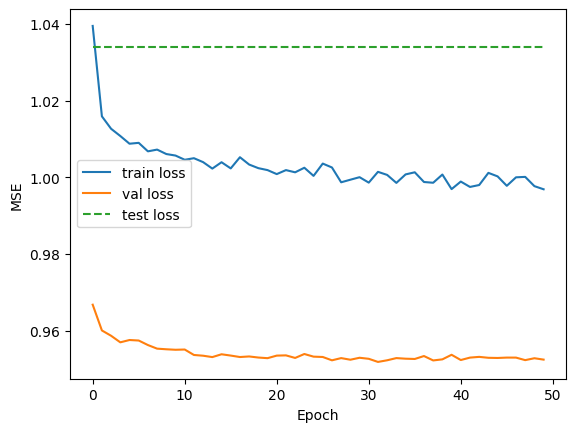

In [14]:
# plot the training history
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot([final_score[0]]*len(history.history['loss']), label='test loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

In [ ]:
y_test.shape

(4035, 1)

In [15]:
# Generate predictions
y_pred = best_model.predict(X_test)

# Inverse transform the predictions
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)


51/51 [==============================] - 0s 2ms/step


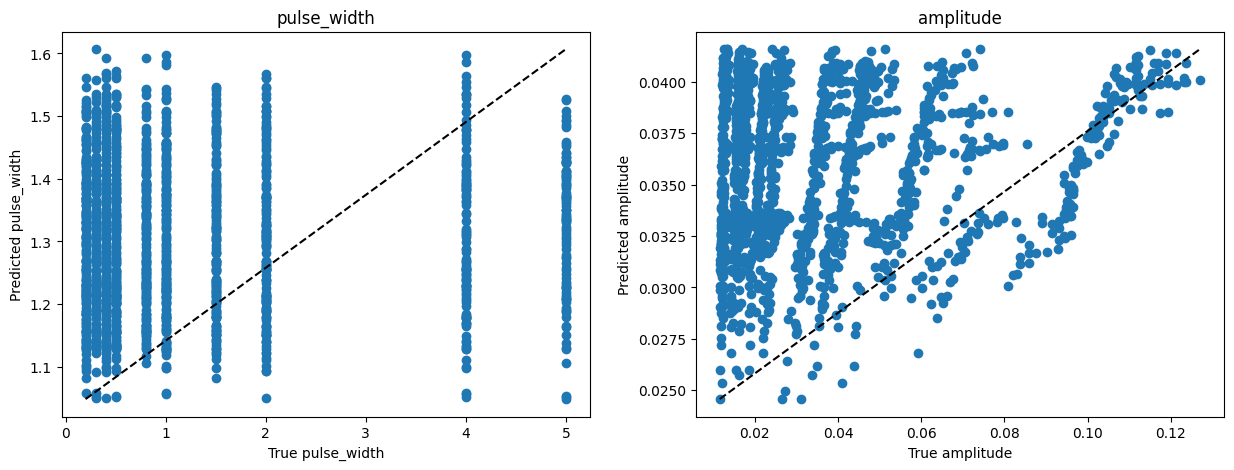

In [16]:
# Plot the predictions for each output
params = ['pulse_width', 'amplitude']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.scatter(y_test[:, i], y_pred[:, i])
    ax.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_pred[:, i]), max(y_pred[:, i])], linestyle='--', color='black')
    ax.set_xlabel(f'True {params[i]}')
    ax.set_ylabel(f'Predicted {params[i]}')
    ax.set_title(f'{params[i]}')

In [ ]:
best_model.save('parameter-model-20240724.keras')

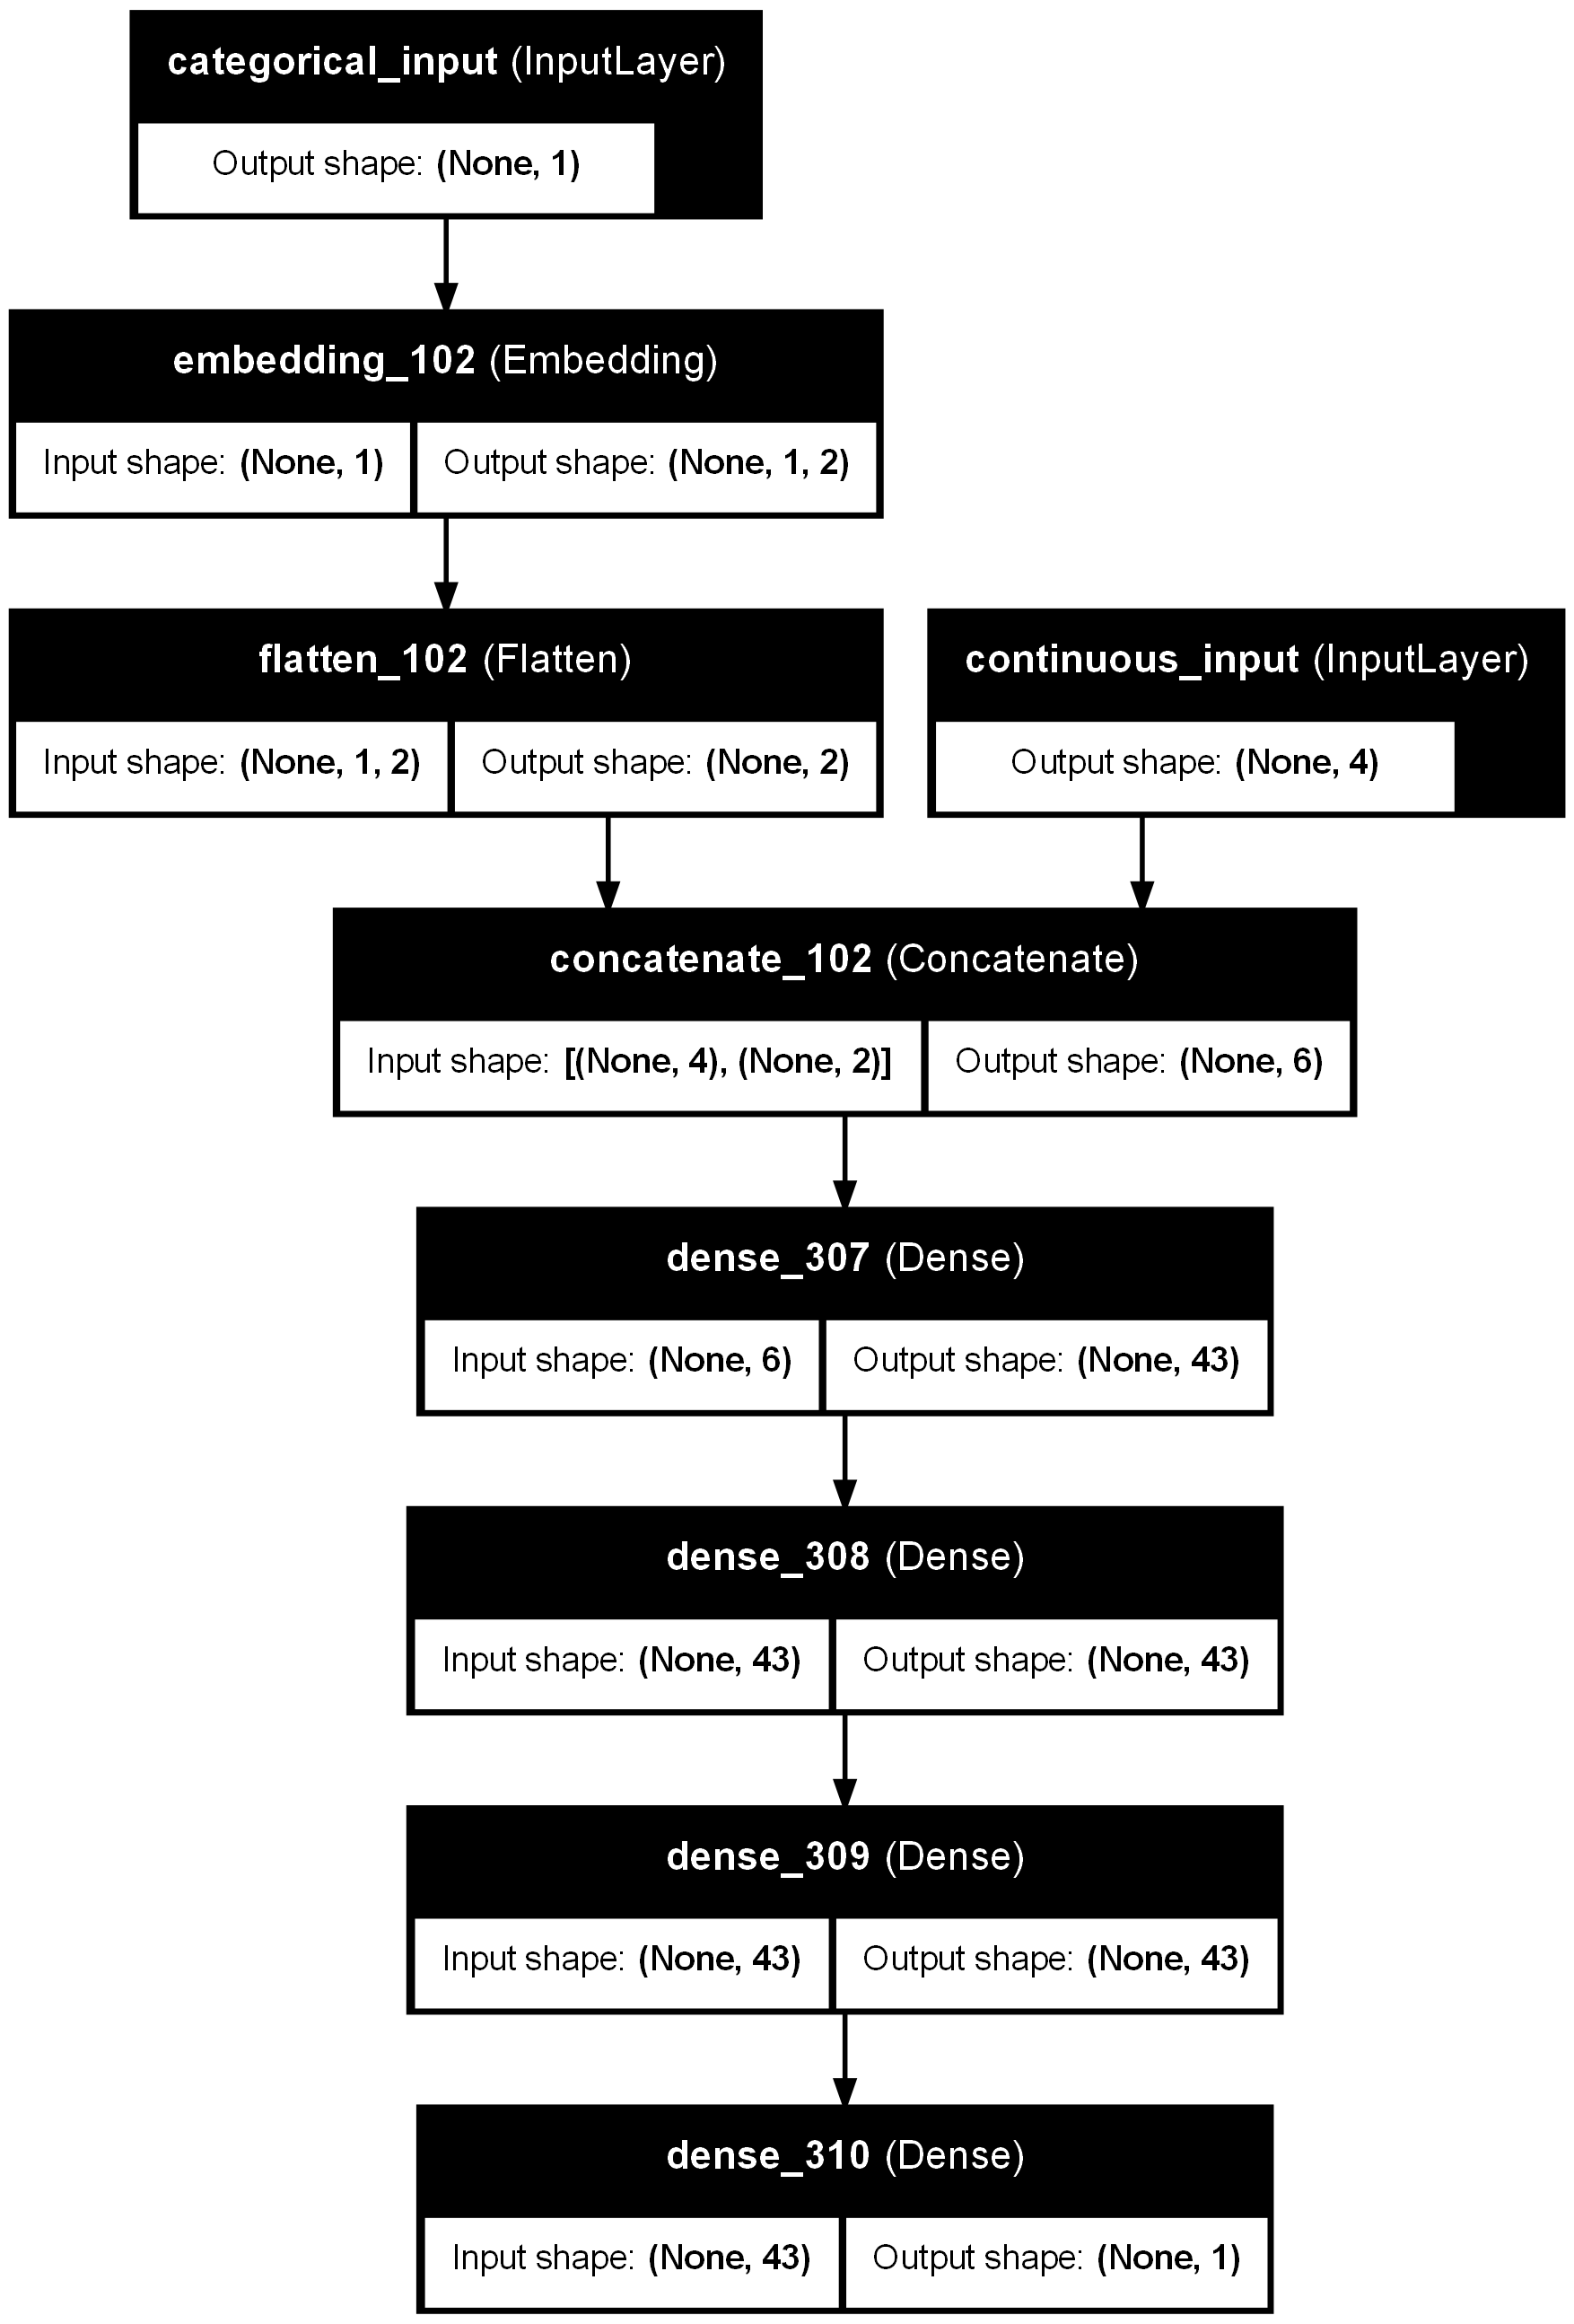

In [ ]:
from keras import utils

utils.plot_model(best_model, show_shapes=True, show_layer_names=True)

In [ ]:
# save study
import pickle

with open('./models/parameters-study.pkl', 'wb') as f:
    pickle.dump(study, f)

In [ ]:
from optuna.visualization import plot_contour

params = [
    'n_layers',
    'layer_size',
    'learning_rate'
]

plot_contour(study, target=lambda t: t.values[0], params=['n_layers', 'layer_size'])